[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Siddhi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Siddhi\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
C:\Users\Siddhi\AppData\Local\Temp\ipykernel_22356\322559146.py:71: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=data['Sentiment'], palette=['green', 'grey', 'red'])


Topic 0:
['dirty', 'people', 'sea', 'like', 'place', 'india', 'historical']


Topic 1:
['place', 'historical', 'sea', 'people', 'india', 'dirty', 'like']


Topic 2:
['india', 'like', 'place', 'dirty', 'people', 'sea', 'historical']




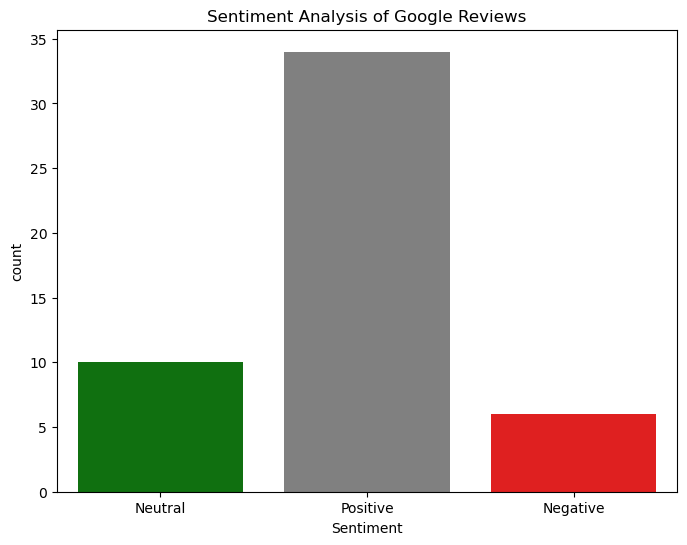

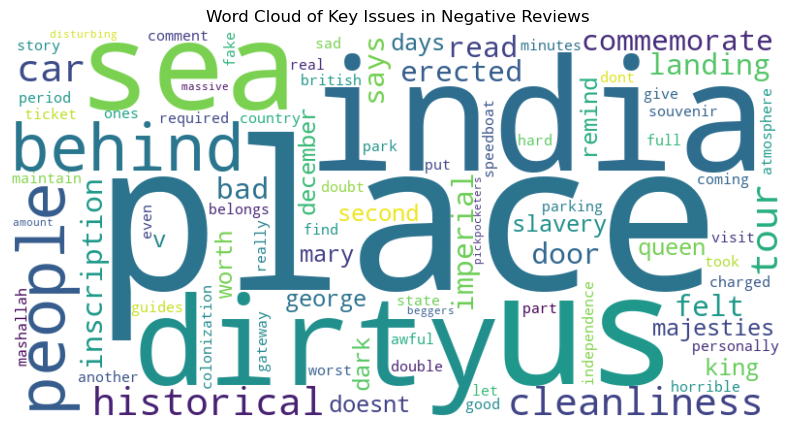

Analysis complete! Processed file saved as 'processed_reviews.csv'.


In [2]:
import pandas as pd
import numpy as np
import re
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
from nltk.sentiment import SentimentIntensityAnalyzer
from textblob import TextBlob
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# Step 1: Load Data (Ensure your Google Reviews file is in CSV format)
file_path = "excel reviews.xlsx"  # Change to your actual file path
data = pd.read_excel(file_path, engine='openpyxl')

# Check data structure
data.head()

# Step 2: Text Preprocessing
def clean_text(text):
    text = re.sub(r'[^a-zA-Z\s]', '', str(text))  # Remove special characters & numbers
    text = text.lower().strip()  # Convert to lowercase
    text = ' '.join([word for word in text.split() if word not in stopwords.words('english')])  # Remove stopwords
    return text

nltk.download('stopwords')
data['Cleaned_Review'] = data['Review_Text'].apply(clean_text)

# Step 3: Sentiment Analysis
nltk.download('vader_lexicon')
sia = SentimentIntensityAnalyzer()

def analyze_sentiment(text):
    score = sia.polarity_scores(text)['compound']
    if score >= 0.05:
        return "Positive"
    elif score <= -0.05:
        return "Negative"
    else:
        return "Neutral"

data['Sentiment'] = data['Cleaned_Review'].apply(analyze_sentiment)

# Step 4: Topic Modeling (Key Issues in Negative Reviews)
negative_reviews = data[data['Sentiment'] == 'Negative']['Cleaned_Review']
vectorizer = CountVectorizer(max_df=0.9, min_df=2, stop_words='english')
X = vectorizer.fit_transform(negative_reviews)
lda = LatentDirichletAllocation(n_components=3, random_state=42)
lda.fit(X)

# Print top words per topic
def print_topics(model, vectorizer, top_n=10):
    words = vectorizer.get_feature_names_out()
    for topic_idx, topic in enumerate(model.components_):
        print(f"Topic {topic_idx}:")
        print([words[i] for i in topic.argsort()[:-top_n - 1:-1]])
        print("\n")

print_topics(lda, vectorizer)

# Step 5: Sustainability Scorecard
kpi_weights = {"Positive": 1, "Neutral": 0.5, "Negative": 0}
data['Sustainability_Score'] = data['Sentiment'].map(kpi_weights)
kpi_summary = data.groupby('Sentiment')['Sustainability_Score'].mean()

# Step 6: Visualization
# Sentiment Distribution
plt.figure(figsize=(8,6))
sns.countplot(x=data['Sentiment'], palette=['green', 'grey', 'red'])
plt.title("Sentiment Analysis of Google Reviews")
plt.show()

# Word Cloud of Negative Reviews
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(negative_reviews))
plt.figure(figsize=(10,6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud of Key Issues in Negative Reviews")
plt.show()

# Exporting results
data.to_csv("processed_reviews.csv", index=False)
print("Analysis complete! Processed file saved as 'processed_reviews.csv'.")
